<a href="https://colab.research.google.com/github/73gon/bitcoin-forecasting-using-ml/blob/main/bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### installations and imports

In [2]:
!pip install tensorflow pandas numpy tweepy transformers praw torch torchvision torchaudio scikit-learn matplotlib plotly aiohttp asyncpraw

from datetime import datetime, timedelta
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
import praw
import asyncpraw
import requests
import pandas as pd
import numpy as np
import time
import logging
import torch
import asyncio
import nest_asyncio
import aiohttp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 27.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

### fetch historical bitcoin data

In [ ]:
def get_binance_data(symbol, interval, start_str, end_str=None):
    base_url = "https://api.binance.com"
    endpoint = "/api/v3/klines"

    start_ts = int(pd.to_datetime(start_str).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_str).timestamp() * 1000) if end_str else None

    data = []
    count = 0

    while True:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ts,
            'limit': 1000
        }
        if end_ts:
            params['endTime'] = end_ts

        try:
            response = requests.get(base_url + endpoint, params=params)
            response.raise_for_status()

            results = response.json()

            if not results:
                break

            data.extend(results)

            start_ts = results[-1][0] + 1

            count += len(results)
            last_timestamp = pd.to_datetime(results[-1][0], unit='ms')
            #print(f"Fetched {count} records, up to {last_timestamp}")

            if len(results) < 1000:
                break

        except requests.exceptions.HTTPError as err:
            if response.status_code == 429:
                print("Rate limit exceeded. Waiting before retrying...")
                time.sleep(60)  # Wait 1 minute before retrying
            else:
                raise err

    return data

def save_to_csv(data, filename):
    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume', 'ignore'
    ]
    df = pd.DataFrame(data, columns=columns)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.to_csv(filename, index=False)

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1m"
    start_date = "2010-01-01"
    end_date = "2024-05-29"

    print("Starting data fetch...")
    data = get_binance_data(symbol, interval, start_date, end_date)
    print("Data fetch complete. Saving to CSV...")
    save_to_csv(data, 'bitcoin_dataset.csv')
    print("Data saved to bitcoin_1min_data.csv")

Starting data fetch...
Data fetch complete. Saving to CSV...
Data saved to bitcoin_1min_data.csv


### initialization sentiment model and configuration of reddit api

In [2]:
# Initialize sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
max_length = 512  # Roberta's maximum sequence length


# Reddit API credentials
client_id = '-DikpAFUeeajlFFyWTBqUg'
client_secret = 'yZu1rPuBINVPuI7LuugQybGwtX1Cdg'
user_agent = 'bitcoin data'
username = '73malik'
password = 'Stapler437581'

# Create Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password,
    check_for_async=False
)

# Subreddit and Keyword definition
subreddit_name = 'all'
keywords = ['bitcoin price prediction', 'bitcoin market analysis', 'bitcoin trend', 'bitcoin forecast', 'bitcoin news']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


### retrieve reddit posts

In [ ]:
# Fetch and analyze Reddit posts
def fetch_reddit_posts(subreddit_name, keywords, start_date, end_date, total_limit=1000, score_threshold=10):
    posts = []
    requests_per_minute = 90  # Adjust this based on the actual API limit
    counter = 0
    current_date = start_date

    while current_date <= end_date:
        for keyword in keywords:
            logging.info(f"Fetching posts for keyword: {keyword} on date: {current_date.strftime('%Y-%m-%d')}")
            search_query = f"{keyword} timestamp:{int(current_date.timestamp())}..{int((current_date + timedelta(days=1)).timestamp())}"

            try:
                submissions = reddit.subreddit(subreddit_name).search(search_query, sort='new', limit=total_limit)
                for submission in submissions:
                    if counter >= total_limit:
                        break
                    if submission.score > score_threshold:
                        created_date = datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                        text = submission.title + " " + submission.selftext
                        sentiment = sentiment_pipeline(text)[0]['label']
                        posts.append({
                            'created': created_date,
                            'title': submission.title,
                            'score': submission.score,
                            'url': submission.url,
                            'content': submission.selftext,
                            'sentiment': sentiment
                        })
                        counter += 1
                        logging.info(f"Fetched post {counter}: {submission.title}")

                    if counter > 0 and counter % requests_per_minute == 0:
                        logging.info(f"Pausing to respect rate limit after {counter} requests.")
                        time.sleep(60)  # Sleep to respect rate limit

                logging.info(f"Finished fetching posts for keyword: {keyword}")

            except Exception as e:
                logging.error(f"Error fetching posts for keyword {keyword}: {e}")
                time.sleep(60)  # Sleep for 1 minute before retrying

        current_date += timedelta(days=1)
        time.sleep(1)  # Sleep to avoid rate limit issues

    logging.info(f"Total posts fetched: {len(posts)}")
    return pd.DataFrame(posts)

# Define the start and end dates for fetching posts
start_date = datetime(2024, 1, 1)  # Adjusted start date to cover a longer period
end_date = datetime(2024, 5, 29)   # Example end date

# Fetch new posts
new_posts_df = fetch_reddit_posts(subreddit_name, keywords, start_date, end_date)

# Save the new posts DataFrame to CSV (replacing old data)
new_posts_df.to_csv('reddit_posts.csv', index=False)
logging.info(f"Total posts processed: {len(new_posts_df)}")
logging.info(f"Total unique posts: {len(new_posts_df)}")

### prepare data

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def prepare_data(price_df, sentiment_df, sequence_length=60):
    sentiment_df['created'] = pd.to_datetime(sentiment_df['created'])
    price_df['timestamp'] = pd.to_datetime(price_df['open_time'])

    price_df = price_df.sort_values('timestamp')
    sentiment_df = sentiment_df.sort_values('created')

    merged_df = pd.merge_asof(price_df, sentiment_df, left_on='timestamp', right_on='created', direction='backward')

    merged_df['sentiment'] = merged_df['sentiment'].fillna('neutral')
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_mapping)

    scaler = MinMaxScaler(feature_range=(0, 1))
    merged_df['close'] = scaler.fit_transform(merged_df['close'].values.reshape(-1, 1))

    if merged_df.isnull().values.any():
        print("Merged DataFrame contains NaN values. Filling NaN values with forward fill.")
        merged_df.fillna(method='ffill', inplace=True)

    data = merged_df[['close', 'sentiment_score']].values
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length][0])

    x, y = np.array(x), np.array(y)

    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        raise ValueError("Prepared data contains NaN values after processing.")
    if np.any(np.isinf(x)) or np.any(np.isinf(y)):
        raise ValueError("Prepared data contains infinite values after processing.")

    return x, y

price_df = pd.read_csv('bitcoin_dataset.csv')
sentiment_df = pd.read_csv('reddit_posts.csv')
x, y = prepare_data(price_df, sentiment_df)
print(f"Prepared data shapes: x={x.shape}, y={y.shape}")

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

x_scaled = scaler_x.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

x_scaled = x_scaled.astype('float32')
y_scaled = y_scaled.astype('float32')

Merged DataFrame contains NaN values. Filling NaN values with forward fill.
Prepared data shapes: x=(118255, 60, 2), y=(118255,)


### build and train lstm model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0, use_bias=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0, use_bias=True))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(1, dtype='float32'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Ensure input data is float32
x_scaled = x_scaled.astype('float32')
y_scaled = y_scaled.astype('float32')

# Build the LSTM model
input_shape = (x_scaled.shape[1], x_scaled.shape[2])
lstm_model = build_lstm_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
lstm_model.fit(x_scaled, y_scaled, batch_size=16, epochs=50, validation_split=0.2, callbacks=[early_stopping, lr_schedule])

# Save the trained model in the newer Keras format
lstm_model.save('lstm_model.keras')

Epoch 1/50
5913/5913 [==============================] - 57s 9ms/step - loss: 0.0062 - val_loss: 0.0626 - lr: 0.0010
Epoch 2/50
5913/5913 [==============================] - 49s 8ms/step - loss: 5.8635e-04 - val_loss: 0.0485 - lr: 0.0010
Epoch 3/50
5913/5913 [==============================] - 48s 8ms/step - loss: 5.4452e-04 - val_loss: 0.0583 - lr: 0.0010
Epoch 4/50
5913/5913 [==============================] - 48s 8ms/step - loss: 5.1917e-04 - val_loss: 0.0549 - lr: 0.0010
Epoch 5/50
5913/5913 [==============================] - 49s 8ms/step - loss: 3.5391e-04 - val_loss: 0.0516 - lr: 1.0000e-04


### predict future prices

Epoch 1/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.6027e-04 - val_loss: 0.0516 - lr: 1.0000e-04
Epoch 2/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.4863e-04 - val_loss: 0.0518 - lr: 1.0000e-04
Epoch 3/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.4102e-04 - val_loss: 0.0503 - lr: 1.0000e-04
Epoch 4/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.3866e-04 - val_loss: 0.0545 - lr: 1.0000e-04
Epoch 5/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.3386e-04 - val_loss: 0.0539 - lr: 1.0000e-04
Epoch 6/50
1479/1479 [==============================] - 12s 8ms/step - loss: 3.2045e-04 - val_loss: 0.0524 - lr: 1.0000e-05


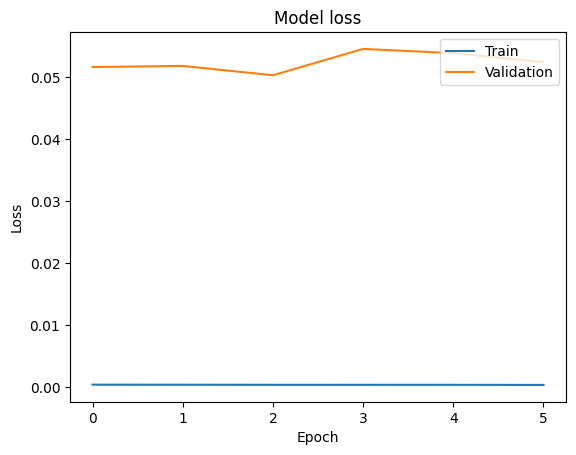

In [5]:
import matplotlib.pyplot as plt

# Training the model (with history)
history = lstm_model.fit(x_scaled, y_scaled, batch_size=64, epochs=50, validation_split=0.2, callbacks=[early_stopping, lr_schedule])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

3696/3696 [==============================] - 12s 3ms/step


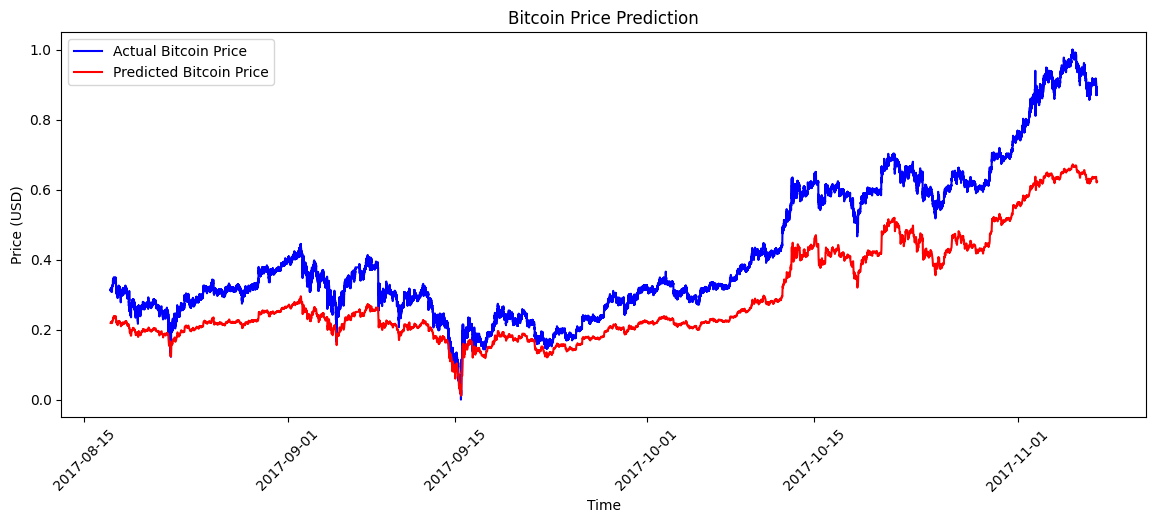

In [18]:
# Assuming you have already fit the scalers during the preparation phase
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# scaler_y.fit(y_train)  # Ensure this was done with the training data

# Load the trained model
lstm_model = load_model('lstm_model.keras')

# Predict future prices
predictions = lstm_model.predict(x_scaled)

# Inverse transform the predictions and actual prices
predicted_prices = scaler_y.inverse_transform(predictions).flatten()
actual_prices = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# Prepare the time axis using the original timestamps
# Assuming you have 'timestamp' column in your price_df which is your date-time series
time_axis = pd.to_datetime(price_df['timestamp'].iloc[60:len(predicted_prices)+60])

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(time_axis, actual_prices, color='blue', label='Actual Bitcoin Price')
plt.plot(time_axis, predicted_prices, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming x_scaled and y_scaled are your preprocessed and scaled data

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

# Build and train the LSTM model
input_shape = (x_train.shape[1], x_train.shape[2])
lstm_model = build_lstm_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
lstm_model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_schedule])

# Make predictions
predictions = lstm_model.predict(x_test)

# Unscale the predictions and actual values
actual_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler_y.inverse_transform(predictions).flatten()

# Calculate AOI
def calculate_aoi(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)

    intersection_area = np.sum(np.minimum(actual, predicted))
    total_area_actual = np.sum(actual)
    total_area_predicted = np.sum(predicted)
    total_area = total_area_actual + total_area_predicted

    aoi = 2 * intersection_area / total_area
    return aoi

aoi_value = calculate_aoi(actual_prices, predicted_prices)
print(f"Average Overlap Index (AOI): {aoi_value:.4f}")

Epoch 1/50
1479/1479 [==============================] - 17s 9ms/step - loss: 0.0226 - val_loss: 0.0167 - lr: 0.0010
Epoch 2/50
1479/1479 [==============================] - 12s 8ms/step - loss: 0.0012 - val_loss: 0.0192 - lr: 0.0010
Epoch 3/50
1479/1479 [==============================] - 12s 8ms/step - loss: 0.0011 - val_loss: 0.0170 - lr: 0.0010
Epoch 4/50
740/740 [==============================] - 3s 3ms/step
Average Overlap Index (AOI): 0.8638
